In [ ]:
# Uncomment this cell if running in Google Colab
# !pip install clinicadl==0.2.0

# Generate saliency maps on trained networks

Explaining black-box models can be useful to better understand their behaviour. For more information on this complex topic, we highly recommend the review of [Xie et al.](http://arxiv.org/abs/2004.14545).

In ClinicaDL, the most basic method of interpretability was implemented: [gradients visualization](https://arxiv.org/pdf/1312.6034.pdf) (sometimes called saliency maps). This method shows how the voxel intensities of an input image should be modified in order to increase the value of a particular output node. Here the output nodes correspond to a label: the first one represents AD whereas the second represents CN.

This method can be performed on an individual or on a group fashion (in this case it will be the mean value of all the individual saliency maps in the group).

## Use of trivial datasets

In the following, we are going to extract saliency maps from a model already trained on a large trivial synthetic dataset. The second line download the mask used for trivial data generation, so we can compare them to the saliency maps obtained.

In [1]:
# Downloading pretrained model


# Downloading masks used for trivial data generation
!curl -k https://aramislab.paris.inria.fr/files/data/masks/AAL2.tar.gz -o AAL2.tar.gz
!tar xf AAL2.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9488k  100 9488k    0     0  5268k      0  0:00:01  0:00:01 --:--:-- 5280k


In this trivial dataset, "AD" brains are atrophied according to the first mask while "CN" brains are atrophied according to the second mask. The first mask include the whole cerebellum + the left hemisphere while the second mask includes the right hemisphere.

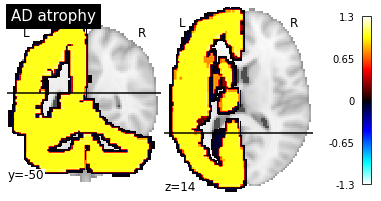

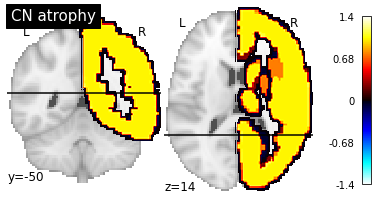

In [49]:
from nilearn import plotting

plotting.plot_stat_map("AAL2/mask-1.nii", title="AD atrophy", cut_coords=(-50, 14), display_mode="yz")
plotting.plot_stat_map("AAL2/mask-2.nii", title="CN atrophy", cut_coords=(-50, 14), display_mode="yz")
plotting.show()

Saliency maps will be generated using trivial data generated from OASIS. If you did not run the previous notebook [Debug architecture search](generate.ipynb), you will need to run the following cell as well:

In [ ]:
# Download trivial CAPS


## Generate individual saliency maps

Saliency maps on corresponding to one image can be computed with the following command:
```bash
clinicadl interpret individual <model_path> <name>
```
where:
- `model_path` is the path to the pretrained model folder,
- `name` is the name of the interpretability job.

Default will try to load the data used for training (which is not possible here). Then you will need to set the following options:
- `--tsv_path`, the path the TSV file with the subjects and sessions to use,
- `--caps_dir`, the path to the CAPS in which the images defined in `tsv_path` are present.

In the following we chose to generate saliency map based on the opposite labels:
- the first command loads AD images and generates saliency maps based on CN node, 
- the second command loads CN images and generates saliency maps based on AD node,

Choosing the target node can be interesting in multi-class problems, but in binary classification we expect the map of the opposite node to have opposite values than the ones in the corresponding node (that is not very interesting).

In [60]:
# AD Target CN
!clinicadl interpret individual "model_trivial" "individual-AD_target-CN" \
    -np 0 --tsv_path "data/synthetic/data.tsv" --caps_dir "data/synthetic" -cpu \
    -d "AD" --target_diagnosis "CN" --nifti_template "AAL2/mask-1.nii"

In [59]:
# CN Target AD
!clinicadl interpret individual "model_trivial" "individual-CN_target-AD" \
    -np 0 --tsv_path "data/synthetic/data.tsv" --caps_dir "data/synthetic" -cpu \
    -d "CN" --target_diagnosis "AD" --nifti_template "AAL2/mask-1.nii"

This command will generate saliency maps for the model selected on validation loss. You can obtain the same maps for the model selection on validation balanced accuracy by adding the option `--selection best_balanced_accuracy`.

One map is generated per image in the folder `gradients/selection/<name>`. These images are organized in a similar way than the CAPS, with a `<participant_id>/<subject_id>` structure:

In [67]:
!tree model_trivial/fold-0/gradients/best_loss/individual-AD_target-CN

model_trivial/fold-0/gradients/best_loss/individual-AD_target-CN
├── commandline.json
├── sub-TRIV0
│   └── ses-M00
│       ├── map.nii.gz
│       └── map.npy
├── sub-TRIV2
│   └── ses-M00
│       ├── map.nii.gz
│       └── map.npy
├── sub-TRIV4
│   └── ses-M00
│       ├── map.nii.gz
│       └── map.npy
└── sub-TRIV6
    └── ses-M00
        ├── map.nii.gz
        └── map.npy

8 directories, 9 files


Then we can plot the individual saliency maps to check which regions the CNN is focusing on.

Plot saliency maps of AD images based on CN nodes


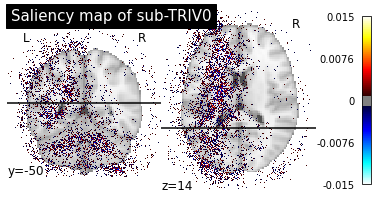

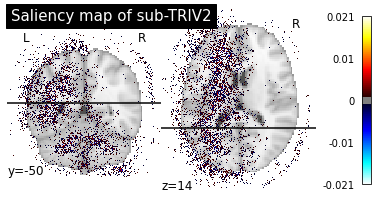

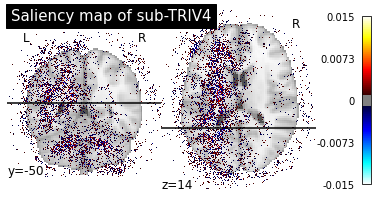

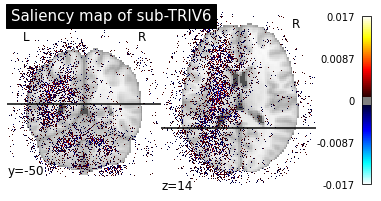

Plot saliency maps of CN images based on AD nodes


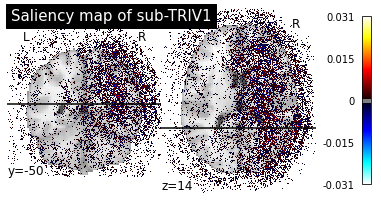

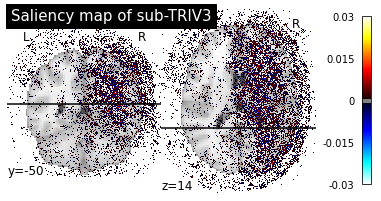

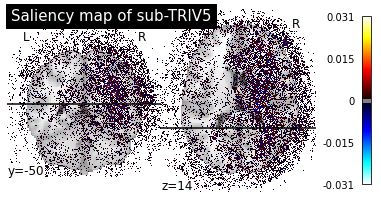

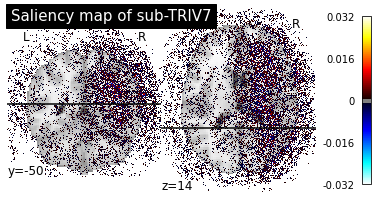

In [65]:
def plot_individual_maps(diagnosis, target):
    import os
    from os import path
    
    subjects_path = f"model_trivial/fold-0/gradients/best_loss/individual-{diagnosis}_target-{target}"
    subjects_list = [subject for subject in os.listdir(subjects_path) 
                     if path.isdir(path.join(subjects_path, subject))]
    subjects_list.sort()
    for subject in subjects_list:
        map_path = path.join(subjects_path, subject, "ses-M00", "map.nii.gz")
        plotting.plot_stat_map(map_path, title=f"Saliency map of {subject}",
                               cut_coords=(-50, 14), display_mode="yz", threshold=10**-3)
    plotting.show()

print("Saliency maps of AD images based on CN nodes")
plot_individual_maps("AD", "CN")
print("Saliency maps of CN images based on AD nodes")
plot_individual_maps("CN", "AD")

These saliency maps are very noisy and may be difficult to interpret. This is why 

## Generate group saliency maps

Saliency maps on corresponding to a group of images can be computed with the following command:
```bash
clinicadl interpret group <model_path> <name>
```
where:
- `model_path` is the path to the pretrained model folder,
- `name` is the name of the interpretability job.

Default will try to load the data used for training (which is not possible here). Then you will need to set the following options:
- `--tsv_path`, the path the TSV file with the subjects and sessions to use,
- `--caps_dir`, the path to the CAPS in which the images defined in `tsv_path` are present.

In [70]:
# AD Target CN
!clinicadl interpret group "model_trivial" "group-AD_target-CN" \
    -np 0 --tsv_path "data/synthetic/data.tsv" --caps_dir "data/synthetic" -cpu \
    -d "AD" --target_diagnosis "CN" --nifti_template "AAL2/mask-1.nii"

In [71]:
# CN Target AD
!clinicadl interpret group "model_trivial" "group-CN_target-AD" \
    -np 0 --tsv_path "data/synthetic/data.tsv" --caps_dir "data/synthetic" -cpu \
    -d "CN" --target_diagnosis "AD" --nifti_template "AAL2/mask-1.nii"

This time the `gradients/<name>` folder will only contain one image corresponding to the mean of individual saliency maps of the group.

In [72]:
!tree model_trivial/fold-0/gradients/best_loss/group-AD_target-CN

model_trivial/fold-0/gradients/best_loss/group-AD_target-CN
├── commandline.json
├── map.nii.gz
└── map.npy

0 directories, 3 files


We can now plot the group saliency maps in the same way than for the individual ones.

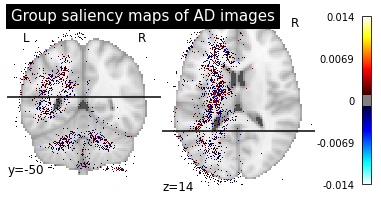

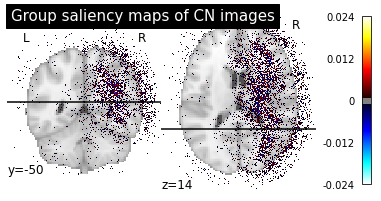

In [73]:
def plot_group_maps(diagnosis, target):    
    map_path = f"model_trivial/fold-0/gradients/best_loss/group-{diagnosis}_target-{target}/map.nii.gz"
    plotting.plot_stat_map(map_path, title=f"Group saliency maps of {diagnosis} images",
                           cut_coords=(-50, 14), display_mode="yz", threshold=10**-3)
    plotting.show()

plot_group_maps("AD", "CN")
plot_group_maps("CN", "AD")

These maps are less noisy as the individual differences are less present and we can see more easily the main pattern.